# Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hidrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [23]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5, Mmulti: int = 10) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M * Mmulti):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip

            samples[succ] = rpos

            if succ >= M-1:
                print(f"Acceptance: {succ / attempt}")
                return samples
    
    raise ValueError(f"Took a total of {M * Mmulti} steps but only {succ} were accepted!")

In [24]:
def sampleNeff(data: np.ndarray, k1percent: float = 0.0, ipercent: float = 0.4) -> int:
    N = len(data)
    k1 = int(k1percent * N)
    k2 = N-1

    icutoff = int(k2 * ipercent)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) for i in range(1, Neq)]) / (var * (Neq - 1))
    timecorr = 1 + 2 * np.sum(autocorr[:icutoff] * (autocorr[:icutoff] > 0))

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.90073264472736
Neff: 24.086016409959647
Energy = -0.16915081241875382
Variance on Energy = 0.02810031113231972

Beta = 0.300
Acceptance: 0.859837193304288
Neff: 41.50463464597792
Energy = -0.24183162079752454
Variance on Energy = 0.02643262256943234

Beta = 0.400
Acceptance: 0.8147645173556413
Neff: 58.43438627344993
Energy = -0.29308723668299824
Variance on Energy = 0.025403961542717172

Beta = 0.500
Acceptance: 0.7683520311459454
Neff: 65.25954171647847
Energy = -0.3554847587482719
Variance on Energy = 0.02712145501594088

Beta = 0.600
Acceptance: 0.7245543693541375
Neff: 89.785419906428
Energy = -0.4080763786437365
Variance on Energy = 0.019774244666940752

Beta = 0.700
Acceptance: 0.6835125774699234
Neff: 116.02028016511213
Energy = -0.43991766723710746
Variance on Energy = 0.014674384198501807

Beta = 0.800
Acceptance: 0.6428785735716429
Neff: 105.84643079074856
Energy = -0.46466207487381095
Variance on Energy = 0.014360414868850303

Beta = 0.900
Accepta

Text(0.5, 1.0, 'Parameter Sweep')

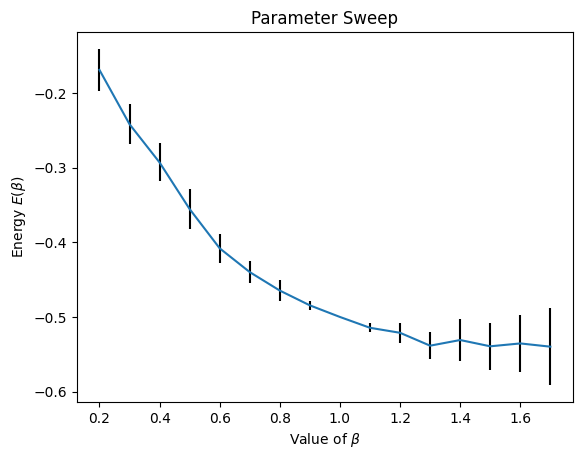

In [27]:
# Parameters
sampleM = 15000
discard = 1500

# Sweep Variational Parameter
betamin = 0.2
betamax = 1.7

Ebeta = []
Estd = []
bb = np.linspace(betamin, betamax, 16)
for beta in bb:
    print(f"Beta = {beta:.3f}")
    Rs = samplePos(sampleM, beta, delta=2, Mmulti=20)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bb[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting

In [18]:
# Parameters
sampleM = 10000
discard = 1000
gamma = 0.01           # Gradient descent constant

# Starting Variational Parameters
beta0 = 1.1
beta1 = 1.2

delta0 = 1/beta
delta1 = 1/beta1

bb = [beta0, beta1]
Ebeta = []
Estd = []

# Want to minimize a function which is average(energy) + varW * std(energy) 
stdW = 0.01

# First run
beta = beta0
delta = delta0
Rs = samplePos(sampleM, beta, delta)
Rs = Rs[discard:]
El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
Estd += [np.std(El) / np.sqrt(len(Rs))]
Ebeta += [np.average(El)]
func0 = np.average(El) + stdW * np.std(El) / np.sqrt(sampleM)

beta = beta1
delta = delta1
Rs = samplePos(sampleM, beta, delta)
Rs = Rs[discard:]
El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
Estd += [np.std(El) / np.sqrt(len(Rs))]
Ebeta += [np.average(El)]
func1 = np.average(El) + stdW * np.std(El) / np.sqrt(sampleM)

while True:
    # Do gradient descent
    beta2 = beta1 - gamma * (func1 - func0) / (beta1 - beta0)

    # Calculate weights
    ww = np.exp(-2 * beta2 * Rs) / np.exp(-2 * beta2 * Rs)

    # Effective points should be high enough
    m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)

    print(m, beta1, beta2)
    print(ww)
    print(np.sum(ww**2))
    print((np.sum(ww))**2)
    if m < 0.5:
        break

    # New energy
    El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
    bb += [beta2]
    Estd += [np.std(El) / np.sqrt(sampleM)]
    Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    func2 = Ebeta[-1] + stdW * np.std(El) / np.sqrt(sampleM)

    # Next step
    beta0 = beta1
    beta1 = beta2

    func0 = func1
    func1 = func2

print(f"Final beta: {beta1}")

plt.errorbar(bb, Ebeta, yerr=Estd)
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

Acceptance: 0.845509893455099
Acceptance: 0.7732580620214987
1.0 1.2 1.2024173869606438
[1. 1. 1. ... 1. 1. 1.]
9000.0
81000000.0
1.0 1.2024173869606438 1.2024173869606438
[1. 1. 1. ... 1. 1. 1.]
9000.0
81000000.0
nan 1.2024173869606438 nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan 

/tmp/ipykernel_925/2371399216.py:41: RuntimeWarning: invalid value encountered in scalar divide
  beta2 = beta1 - gamma * (func1 - func0) / (beta1 - beta0)


nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]
nan
nan
nan nan nan
[nan nan nan ... nan nan nan]


KeyboardInterrupt: 

Beta = 
0.2
Mean = 
-0.19291609143412008
Correlated Error = 
0.1487717774057992
Acceptance Rate = 
0.9052214996837106
Cut off ratio (M / K) = 
5.1972482577670265
Uncorrelated Error estimate = 
0.009728089635834622
Correlation time = 
57.722853541134015
     
Beta = 
0.30000000000000004
Mean = 
-0.26109443217182465
Correlated Error = 
0.19996982150957182
Acceptance Rate = 
0.8589272589618042
Cut off ratio (M / K) = 
6.61201664723379
Uncorrelated Error estimate = 
0.011592877129852788
Correlation time = 
45.371936582390234
     
Beta = 
0.4
Mean = 
-0.3046413695311548
Correlated Error = 
0.2088468091438979
Acceptance Rate = 
0.8150579286979851
Cut off ratio (M / K) = 
7.897402646044391
Uncorrelated Error estimate = 
0.011078461351756493
Correlation time = 
37.9871729283377
     
Beta = 
0.5
Mean = 
-0.36809074896220034
Correlated Error = 
0.2303742782481481
Acceptance Rate = 
0.7679367191867744
Cut off ratio (M / K) = 
12.788111978193603
Uncorrelated Error estimate = 
0.00960338887817228

/tmp/ipykernel_925/3965575736.py:61: RuntimeWarning: invalid value encountered in scalar divide
  K = 1+2*sum/v


Cut off ratio (M / K) = 
nan
Uncorrelated Error estimate = 
nan
Correlation time = 
nan
     
Beta = 
1.1
Mean = 
-0.49727566642827514
Correlated Error = 
0.10455745600295459
Acceptance Rate = 
0.5364786304047053
Cut off ratio (M / K) = 
19.470817062430843
Uncorrelated Error estimate = 
0.003532292528969567
Correlation time = 
15.407673906959628
     
Beta = 
1.2
Mean = 
-0.48590804245631813
Correlated Error = 
0.19933292337855119
Acceptance Rate = 
0.5093459860630775
Cut off ratio (M / K) = 
18.546139454015815
Uncorrelated Error estimate = 
0.006899951191702979
Correlation time = 
16.17587319149812
     
Beta = 
1.3
Mean = 
-0.4443522918657242
Correlated Error = 
0.48393402737057395
Acceptance Rate = 
0.4783076102710687
Cut off ratio (M / K) = 
24.715881759393856
Uncorrelated Error estimate = 
0.014510816456422132
Correlation time = 
12.137944456947318
     
Beta = 
1.4000000000000001
Mean = 
-0.3952384406758066
Correlated Error = 
0.5994317134976594
Acceptance Rate = 
0.4485550467670

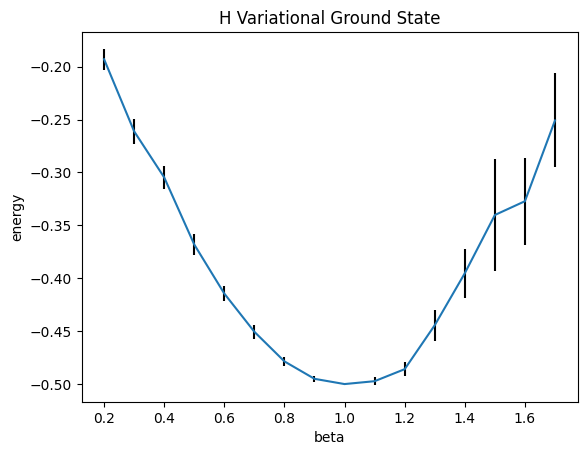

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, log, exp, mean, var
from random import random as rand
# h = -1/2 \nabla^2 - 1/r, psi=exp(-\beta r)

# Wave function of the form exp(-beta*r)

# First we create a random walk
def rad(x,y,z):
    return sqrt(x*x + y*y + z*z)

def monte_carlo(beta):
    N = 15000 # num of steps
    t_eq = 1500 # num of steps to equilibrate
    rand_walk = np.zeros((N - t_eq, 2), dtype = float)
    delta = 2
    x,y,z = 10.0, 0.1, 0.01
    r = rad(x,y,z)
    logpsi = -beta*r
    ekin = -0.5*beta*(beta-2/r)
    epot =-1.0/r
    etot = ekin + epot
    for i in range(N):
        xp = x + delta*(rand() - 0.5)
        yp = y + delta*(rand() - 0.5)
        zp = z + delta*(rand() - 0.5)
        rp = rad(xp,yp,zp)
        logpsip = -beta*rp
        p = min(1, exp(2*(logpsip - logpsi)))
        if p > rand():
            x = xp
            y = yp
            z = zp
            r = rp
            logpsi = -beta*r
            ekin=-0.5*beta*(beta-2/r)
            epot=-1.0/r
            etot=ekin+epot
        if i < t_eq:
            continue
        rand_walk[i-t_eq] = [p, etot]
    return rand_walk

# Now we process the data to remove autocorrelation

def offset_corr(arr, N, a, i):
    sum = 0
    for j in range(N-i):
        sum += (arr[j]-a)*(arr[j+i] - a)
    return sum / (N - i)

def corr_time(arr):
    N = len(arr)
    a = np.mean(arr)
    v = np.var(arr, ddof = 1)
    M = 300 # cut off
    sum = 0
    for i in range(100): # HERE DECIDE CUTOFF ON i.
        sum += offset_corr(arr, N, a, i)
    K = 1+2*sum/v
    err = np.sqrt(v*abs(K)/N)
    print("Cut off ratio (M / K) = ")
    print(M / K)
    print("Uncorrelated Error estimate = ")
    print(err)
    print("Correlation time = ")
    print(K)
    return err

def reblock(arr):
    K = corr_time(arr)
    print(K)
    if K <= 0:
        print("!! Corr time < 0 !!")
    return arr[::abs(int(K))]

"""
b_vals = np.linspace(0, 5, 26)
E_arr = np.zeros(26)
for i in range(26):
    beta = b_vals[i]
    arr = monte_carlo(beta)
    E_arr[i] = np.mean(arr[:,1])
    
plt.plot(b_vals, E_arr)
plt.show()
"""


def main(test_values):
    L = len(test_values)
    E_vals = np.zeros(L)
    errors = np.zeros(L)
    for i in range(L):
        beta = test_values[i]
        arr = monte_carlo(beta)

        print("Beta = ")
        print(beta)

        E = np.mean(arr[:,1])
        print("Mean = ")
        print(E)

        print("Correlated Error = ")
        print(np.std(arr[:,1], ddof = 1))

        print("Acceptance Rate = ")
        print(np.mean(arr[:,0]))

        E_vals[i] = E
        errors[i] = corr_time(arr[:,1])

        print("     ")

    plt.errorbar(test_values, E_vals, yerr = errors, ecolor = 'black')
    plt.title("H Variational Ground State")
    plt.xlabel("beta")
    plt.ylabel("energy")
    plt.show()
        
"""
arr = monte_carlo(1.3)
print("Acceptance rate is: " + str(np.mean(arr[:,0])))
evals = arr[:,1]
print(evals)
print(corr_time(evals))
print(np.var(evals,ddof=1))
"""

test = np.linspace(betamin, betamax, 16)

main(test)
